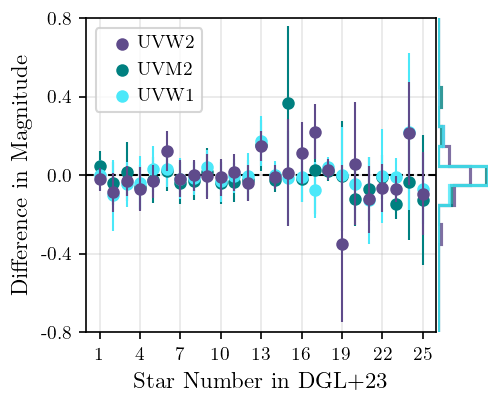

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import os 

# Compares the current pipeline with a previous version of the pipeline used in DGL+23
# Plots differences in UVW2, UVM2, UVW1 photometry between this work and DGL+23

colors  = ['#5f4b8b','#008080','#4be8f9'] 

# Set dir depending on machine 
data_dir = os.getenv("DATADIR")
directory = data_dir + '0_SUMS_Catalogs/'

def Quad(X1,X2):
    return np.sqrt(X1**2+X2**2)

# Import photometry from SUMS catalog
lmc = pd.read_csv(directory+'CompleteCatalog/Step5/lmc_colors.csv')
smc = pd.read_csv(directory+'CompleteCatalog/Step5/smc_colors.csv')

# Add column to indicate what galaxy they are in 
lmc['galaxy'] = 'lmc'
smc['galaxy'] = 'smc'

# Combine together
df = pd.concat([lmc, smc])

# Drop any unnamed columns
df = df.drop([col for col in df.columns if 'Unnamed' in col], axis=1)

# Reset index
df = df.reset_index(drop=True)

# Add Discovery Name
discovery_ra = [15.24876,14.25651,14.41704,16.00199,77.20574,76.19464,82.00481,86.86671,81.58229,77.16778,77.84628,83.11642,81.8678,80.916,84.05355,83.89011,81.69701,80.48712,78.34581,84.13771,15.48006,15.84282,15.92665,12.68916,15.97596]
discovery_dec = [-72.62048,-72.60092,-71.98791,-72.27852,-69.0916,-69.04014,-69.99687,-69.1021,-69.37607,-69.18455,-69.8981,-70.30682,-68.68436,-68.61127,-69.45609,-70.31835,-68.82376,-69.42087,-69.37446,-69.44082,-72.45029,-72.10988,-72.02792,-73.26791,-72.12816]
discovery_coord = SkyCoord(discovery_ra, discovery_dec, unit='deg')
discovery_name = ['Star_1','Star_2','Star_3','Star_4','Star_5','Star_6','Star_7','Star_8','Star_9','Star_10','Star_11','Star_12','Star_13','Star_14','Star_15','Star_16','Star_17','Star_18','Star_19','Star_20','Star_21','Star_22','Star_23','Star_24','Star_25']
df_co = SkyCoord(df['ra'], df['dec'], unit='deg')
for name, coordinate in zip(discovery_name, discovery_coord):
    distances = coordinate.separation(df_co).arcsecond
    min_distance = np.min(distances)
    row = df[distances == min_distance]
    # If no matching source is found, print the minimum distance and the name of the source
    if min_distance > 0.1:
        print(min_distance)
        print(name)
    # Otherwise add it to the dataframe
    else:
        df.loc[row.index,'discovery_name'] = name
df = df[~df['discovery_name'].isnull()].reset_index(drop=True)

# Sort by Star number so they are comparable when we take the difference
df['Star'] = df['discovery_name'].str.extract(r'(\d+)')
df['Star'] = df['Star'].astype(int)
df = df.sort_values(by='Star')
df = df.reset_index(drop=True)

# Import photometry from DGL+23
cols = ['Star', 'RA', 'DEC', 'n5', 'closest', 'uvw2', 'W2-FF','uvm2', 'M2-FF', 'uvw1', 'W1-FF', 'U', 'B', 'V', 'I']
uv_filters = ['uvw2', 'uvm2', 'uvw1']
disc = pd.read_csv(directory+'Drout23/Photometry.txt', delimiter='\\&', names=cols, engine='python',comment='#',header=None)
for uvfilter in uv_filters:
    # Split col by '\t'
    col = disc[uvfilter].str.split('\t', expand=True)
    disc[uvfilter] = col[1]
    disc[f'{uvfilter}_err'] = col[3]
    # SUMS Catalog - Discovery Paper 
    disc[f'{uvfilter}_diff']  = df[uvfilter] - disc[uvfilter].astype(float)
    # Reminder this is the combined error in both measurements
    disc[f'{uvfilter}_diff_err'] = Quad(df[f'{uvfilter}_err'], disc[f'{uvfilter}_err'].astype(float))

disc.to_csv(directory+'Drout23/Photometry.csv')

# PLOTTING
plt.style.use(data_dir+'bl.mplstyle')

fig = plt.figure(figsize=(3.35, 3.35),dpi=150)
gs = fig.add_gridspec(2, 2,  width_ratios=(7,1),height_ratios=(1, 4),left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.01, hspace=0.05)
ax = fig.add_subplot(gs[1,0])
bx = fig.add_subplot(gs[1,1],sharey=ax)


# Plot scatter points
ax.errorbar(disc['Star'], disc['uvw2_diff'],yerr=disc['uvw2_diff_err'],fmt='o',c=colors[0],zorder=10)
ax.errorbar(disc['Star'], disc['uvm2_diff'],yerr=disc['uvm2_diff_err'],fmt='o',c=colors[1])
ax.errorbar(disc['Star'], disc['uvw1_diff'],yerr=disc['uvw1_diff_err'],fmt='o',c=colors[2])
# Plot some dummy points for the legend
ax.scatter(0,-1,c=colors[0],label='UVW2')
ax.scatter(0,-1,c=colors[1],label='UVM2')
ax.scatter(0,-1,c=colors[2],label='UVW1')
# Residual Line 
ax.axhline(0,c='k',ls='--')
# Labels 
ax.set_xlabel('Star Number in DGL+23',color='black')
ax.set_ylabel('Difference in Magnitude',color='black')
# Legend 
ax.legend(loc='upper left',handletextpad=-0.2)
# Limits
ax.set_xlim(0,26)
ydim = [-0.8,0.8]
ax.set_ylim(ydim)
ax.grid(True,alpha=0.3)
# Ticks 
ax.set_xticks(np.arange(1,26,3))
ax.set_xticklabels([str(i) for i in np.arange(1,26,3)])

# HISTOGRAM 
ybins = np.linspace(ydim[0],ydim[1],16)
binwidth = 0.1
ybins = np.arange(-0.8 - (binwidth/2), 0.8 +binwidth, binwidth)
# Regular Counts
hist_lw = 1.5 
hist, bins, _ = bx.hist(disc['uvw2_diff'],bins=ybins,color=colors[0],alpha=0.8,histtype='step',orientation='horizontal',range=(ydim[0],ydim[1]),lw=hist_lw)
hist, bins, _ = bx.hist(disc['uvm2_diff'],bins=ybins,color=colors[1],alpha=0.8,histtype='step',orientation='horizontal',range=(ydim[0],ydim[1]),lw=hist_lw)
hist, bins, _ = bx.hist(disc['uvw1_diff'],bins=ybins,color=colors[2],alpha=0.8,histtype='step',orientation='horizontal',range=(ydim[0],ydim[1]),lw=hist_lw)
bx.set_ylim(ydim)
# Turn off ylabel and axis 
bx.set_yticklabels([])
# Turn off spines 
bx.spines['left'].set_visible(False)
bx.spines['right'].set_visible(False)
bx.spines['top'].set_visible(False)
bx.spines['bottom'].set_visible(False)
bx.yaxis.set_visible(False)
bx.set_xlim(0,19)
xticks = [0,10]
bx.set_xticks([])
bx.set_xticklabels([])
ax.set_yticks(np.arange(-0.8,0.9,0.4))
ax.set_yticklabels([f'{i:<.1f}' for i in np.arange(-0.8,0.9,0.4)])

plt.savefig(f'ComparisonToDiscovery.pdf',bbox_inches='tight',dpi=1000)